<font size="5"> Data Manipulation using DASK and Causal Inference using Diff-in-Diff approach

In [2]:
import requests, json, time, statistics, aiohttp, pandas as pd, numpy as np, altair as alt

from datetime import datetime, date, timedelta
from dateutil.relativedelta import relativedelta

# DASK
import dask.array as da
import dask.dataframe as dd
import dask.bag as bag
from dask.distributed import LocalCluster, Client

pd.set_option('display.max_columns', 500)

<font size="3"> Dataset Source:

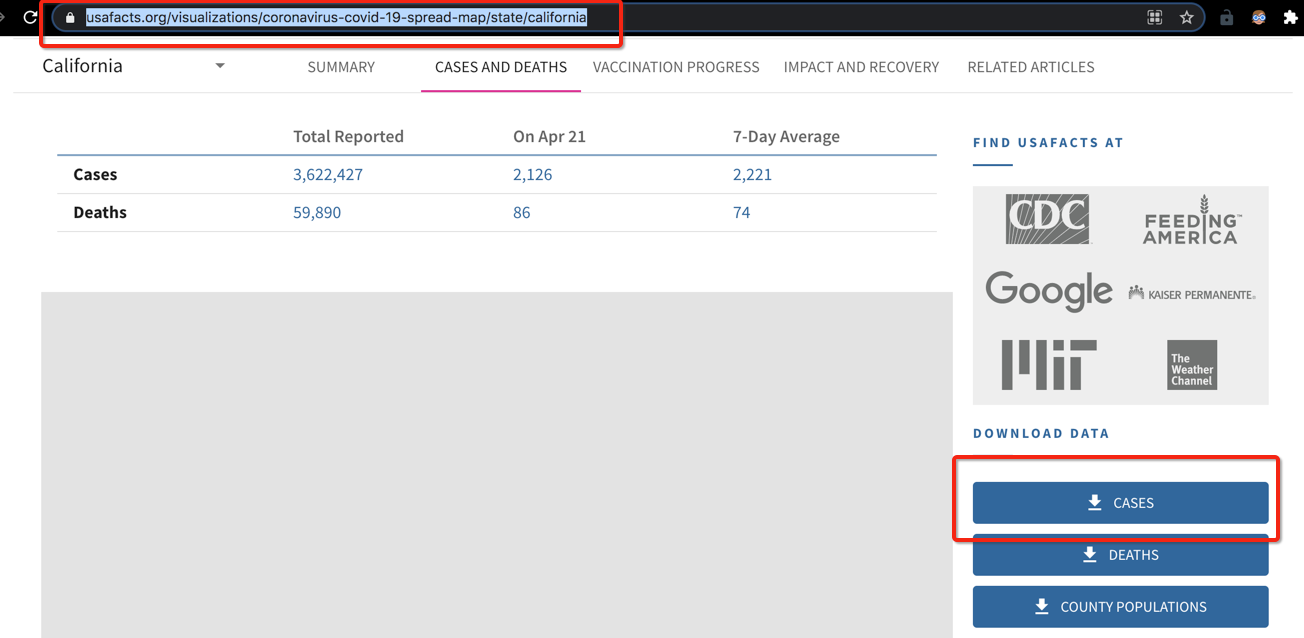

<font size="3"> This has data for all counties of all states in USA. Dataset is comprehensive

In [6]:
s = pd.read_csv('/Users/adityahpatel/Desktop/PYTHON PROGRAMS/Milestone Project/covid_confirmed_usafacts.csv')
cali = s[s.State == 'CA']   # Pulling out all counties of California, same can be done for NY state
cali

,countyFIPS,County Name,State,StateFIPS,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,2020-02-01,2020-02-02,2020-02-03,2020-02-04,2020-02-05,2020-02-06,2020-02-07,2020-02-08,2020-02-09,2020-02-10,2020-02-11,2020-02-12,2020-02-13,2020-02-14,2020-02-15,2020-02-16,2020-02-17,2020-02-18,2020-02-19,2020-02-20,2020-02-21,2020-02-22,2020-02-23,2020-02-24,2020-02-25,2020-02-26,2020-02-27,2020-02-28,2020-02-29,2020-03-01,2020-03-02,2020-03-03,2020-03-04,2020-03-05,2020-03-06,2020-03-07,2020-03-08,2020-03-09,2020-03-10,2020-03-11,2020-03-12,2020-03-13,2020-03-14,2020-03-15,2020-03-16,2020-03-17,2020-03-18,2020-03-19,2020-03-20,2020-03-21,2020-03-22,2020-03-23,2020-03-24,2020-03-25,2020-03-26,2020-03-27,2020-03-28,2020-03-29,2020-03-30,2020-03-31,2020-04-01,2020-04-02,2020-04-03,2020-04-04,2020-04-05,2020-04-06,2020-04-07,2020-04-08,2020-04-09,2020-04-10,2020-04-11,2020-04-12,2020-04-13,2020-04-14,2020-04-15,2020-04-16,2020-04-17,2020-04-18,2020-04-19,2020-04-20,2020-04-21,2020-04-22,2020-04-23,2020-04-24,2020-04-25,2020-04-26,2020-04-27,2020-04-28,2020-04-29,2020-04-30,2020-05-01,2020-05-02,2020-05-03,2020-05-04,2020-05-05,2020-05-06,2020-05-07,2020-05-08,2020-05-09,2020-05-10,2020-05-11,2020-05-12,2020-05-13,2020-05-14,2020-05-15,2020-05-16,2020-05-17,2020-05-18,2020-05-19,2020-05-20,2020-05-21,2020-05-22,2020-05-23,2020-05-24,2020-05-25,2020-05-26,2020-05-27,2020-05-28,2020-05-29,2020-05-30,2020-05-31,2020-06-01,2020-06-02,2020-06-03,2020-06-04,2020-06-05,2020-06-06,2020-06-07,2020-06-08,2020-06-09,2020-06-10,2020-06-11,2020-06-12,2020-06-13,2020-06-14,2020-06-15,2020-06-16,2020-06-17,2020-06-18,2020-06-19,2020-06-20,2020-06-21,2020-06-22,2020-06-23,2020-06-24,2020-06-25,2020-06-26,2020-06-27,2020-06-28,2020-06-29,2020-06-30,2020-07-01,2020-07-02,2020-07-03,2020-07-04,2020-07-05,2020-07-06,2020-07-07,2020-07-08,2020-07-09,2020-07-10,2020-07-11,2020-07-12,2020-07-13,2020-07-14,2020-07-15,2020-07-16,2020-07-17,2020-07-18,2020-07-19,2020-07-20,2020-07-21,2020-07-22,2020-07-23,2020-07-24,2020-07-25,2020-07-26,2020-07-27,2020-07-28,2020-07-29,2020-07-30,2020-07-31,2020-08-01,2020-08-02,2020-08-03,2020-08-04,2020-08-05,2020-08-06,2020-08-07,2020-08-08,2020-08-09,2020-08-10,2020-08-11,2020-08-12,2020-08-13,2020-08-14,2020-08-15,2020-08-16,2020-08-17,2020-08-18,2020-08-19,2020-08-20,2020-08-21,2020-08-22,2020-08-23,2020-08-24,2020-08-25,2020-08-26,2020-08-27,2020-08-28,2020-08-29,2020-08-30,2020-08-31,2020-09-01,2020-09-02,2020-09-03,2020-09-04,2020-09-05,2020-09-06,2020-09-07,2020-09-08,2020-09-09,2020-09-10,2020-09-11,2020-09-12,2020-09-13,2020-09-14,2020-09-15,2020-09-16,2020-09-17,2020-09-18,2020-09-19,2020-09-20,2020-09-21,2020-09-22,2020-09-23,2020-09-24,2020-09-25,2020-09-26,2020-09-27,2020-09-28,2020-09-29,2020-09-30,2020-10-01,2020-10-02,2020-10-03,2020-10-04,2020-10-05,2020-10-06,2020-10-07,2020-10-08,2020-10-09,2020-10-10,2020-10-11,2020-10-12,2020-10-13,2020-10-14,2020-10-15,2020-10-16,2020-10-17,2020-10-18,2020-10-19,2020-10-20,2020-10-21,2020-10-22,2020-10-23,2020-10-24,2020-10-25,2020-10-26,2020-10-27,2020-10-28,2020-10-29,2020-10-30,2020-10-31,2020-11-01,2020-11-02,2020-11-03,2020-11-04,2020-11-05,2020-11-06,2020-11-07,2020-11-08,2020-11-09,2020-11-10,2020-11-11,2020-11-12,2020-11-13,2020-11-14,2020-11-15,2020-11-16,2020-11-17,2020-11-18,2020-11-19,2020-11-20,2020-11-21,2020-11-22,2020-11-23,2020-11-24,2020-11-25,2020-11-26,2020-11-27,2020-11-28,2020-11-29,2020-11-30,2020-12-01,2020-12-02,2020-12-03,2020-12-04,2020-12-05,2020-12-06,2020-12-07,2020-12-08,2020-12-09,2020-12-10,2020-12-11,2020-12-12,2020-12-13,2020-12-14,2020-12-15,2020-12-16,2020-12-17,2020-12-18,2020-12-19,2020-12-20,2020-12-21,2020-12-22,2020-12-23,2020-12-24,2020-12-25,2020-12-26,2020-12-27,2020-12-28,2020-12-29,2020-12-30,2020-12-31,2021-01-01,2021-01-02,2021-01-03,2021-01-04,2021-01-05,2021-01-06,2021-01-07,2021-01-08,2021-01-09,2021-01-10,2021-01-11,2021-01-12,2021-01-13,2021-01-14,2021-01-15,

<font size="4"> Find Causal effect of Coronavirus on home prices in Los Angeles County

<font size="3"> Hypothesis/Intuition before commencing analysis:
    
> We hypothesize home prices to fall due to Covid. We think Covid may have led to weakened demand for houses, 
due to some people losing jobs hence moving to rental units, some people falling sick hence pausing their plans of buying new house (or upgrading to a bigger house), changes in attitudes towards perceived risk of real estate investing among other factors.  

<font size="3"> What is diff-in-diff (DiD) method?
    
> DiD method is a common statistical technique used to draw causal inferences from observational data. It calculates the causal effect of a treatment (e.g. a sudden change like a new tax introduction or a Govt policy change or Covid hitting world, etc) on an outcome variable (e.g. median home price of single family homes) by comparing the average change over time in the outcome variable for the treatment group, compared to the average change over time for the control group.

> With the unexpected advent of Covid-19 in our world, it is reasonable to ask how it affected home prices in our local county. This is difficult to find out because in order to truly know how those home prices have been impacted, we need to consider how those home prices would be had the world never experienced Covid-19 (the counterfactual). However, the Covid-19 did hit the world, and we don't get to observe how those home prices would fair without Covid-19. 
    
> DiD uses the outcome of the control group as a proxy/counterfactual for what would have occurred in the treatment group had there been no treatment. The difference in the average post-treatment outcomes between the treatment and control groups is a measure of the causal effect.

In [9]:
# Set up: Discussion with Prof. Alain Cohn on setting up simple DiD 
# (Assumptions are listed as A1, A2, A3)

  
# (2) Identify 2 counties (treatment and control) preferably in same state 
#     where Covid cases reached a threshold (A2: 10K cases, when ppl startes losing jobs and not when
#     1st cases was reported...companies realized this virus is here to stay) at 2 different points of time..

# (3) Alameda county hit 5000 cases 06/22/2020 and 10,000 cases on 07/24/2020
#     Sacramento county hit 5000 cases 07/10/2020 and 10,000 cases on 08/01/2020
#     Los Angeles county hit 5000 cases 04/04/2020 and 10,000 cases on 04/14/2020
#     San Francisco county hit 5000 cases on 07/18/2020 and 10,000 cases on 09/08

# DEFINITIONS:

#  Outcome variable: Median Home Price in dollars
# "Treatment" variable : Covid cases reaching a critical threshold of 10,000 cases in the county. 

# Treatment Group: Los Angeles county (exposed to treatment in period 2 but NOT in period 1)
# Control Group: San Francisco county (not exposed to treatment in either period 1 or period 2). Counterfactual

# Post-Treatment Period: 04/14/2020 to 05/14/2020 (Post Treatment Period)
# Pre-Treatment Period:  04/14/2019 to 05/14/2019 (Pre-Treatment Period)

# NOTES: 
# In Pre-Treatment period, both counties were not treated  
# In Post-Treatment period, treatment county (LA) saw Covid hit critical threshold, but control county (SF)did not.

# Parallel Trends assumption (Untestable in practice): If Covid had not hit, the time trend in Los Angeles would 
# match time trend of San Francisco. This seems reasonable to us considering both are top counties in SAME state 
# and have many similarities. There is nothing unique to LA or SF county that changed over time. Anything that 
# changes over time affects treatment (LA) and control (SF) group in the same way. i.e. there are no time-varying 
# LA or SF specific confounders i.e. anything that changes over time that might affect median home prices cannot 
# differ between LA and SF (treatment and control)

# FYI we don't envision any unobserved confounders. Confounder is something that affects Covid cases and also 
# home prices. MORE importantly, identifying unobserved confounders doesn't matter because we assume whatever 
# are those confounders for SF (our counterfactual),the same confounders will also confound Covid cases and home 
# prices in LA county. This therefore nullifies their effect in our analysis. There are no systematic differences 
# in the changes of unobserved confounders.

# Calculate simple Difference-in-Difference of Median Home Price of Single Family Homes as the causal effect of
# Covid on Home Prices in Los Angeles county

In [10]:
# Differences in Differences approach:
# Discussed with Prof. Alain Cohn How to choose treatment and control group? 
# i.e. decide how to define the "treatment"? 
# 2 options: 
# (1) Use time as treatment i.e. March '20 to Oct '20 as treatment and Oct 19 - Feb 20 as control 
# (2) Use 2 different counties where Covid hit one earlier, so that at t=1, 1 county hit 5000 cases, other didn't
# Read paper How does Covid affect house prices? A cross city analysis by BingBing Wang 

#
# The DD model includes several pieces:
# A sudden exogenous source of variation (i.e. CHANGE), which we refer to as the treatment. Treatment examples include 
# changes in minimum wage, a new tax, a new policy, Covid cases reaching a threshold, 


In [ ]:
# Visualization:
# Create 

## CO06075 is San Francisco county 
## CO06037 is LA county


### Losangeles pre-treatment

In [ ]:
path = '/Users/adityahpatel/Desktop/PYTHON PROGRAMS/Housing Full Dataset/CO06037 *'
def work_read(filepath):
    b = bag.read_text(filepath).map(json.loads) 
    b = b.flatten()   # without flattening the bag, the results in the bag will be useless due to excessive nesting
    return b
bag_la = work_read(path)

In [ ]:
bag_la.count().compute() # before filtering there are 150501 dictionaries in bag

In [ ]:
bag_la.take(1)   # this is like .head(1) but for bag instead of pandas df


In [ ]:
# Required for Dask. Do not delete this.
bag_la = bag_la.filter(lambda x:'saleTransDate' in x['sale'].keys()).filter(lambda x:'proptype' in x['summary'].keys())
bag_la.count().compute()


In [ ]:
def filters_pretreatment(bag_item):  # enter yyyy, mm, dd for start and end so 6 variables
    condition1 = 'sale' in bag_item.keys()
    condition2 = 'proptype' in bag_item['summary'].keys()
    condition3 = 'amount' in bag_item['sale'].keys()
    condition4 = 'saleamt' in bag_item['sale']['amount'].keys()
    date = datetime.strptime(bag_item['sale']['saleTransDate'], '%Y-%m-%d') 
    condition5 = (date >= datetime(2019,4,14)) & (date < datetime(2019,5,15))
    condition6 = 'saleTransDate' in bag_item['sale'].keys()
    condition7 = bag_item['summary']['proptype'] == 'SFR'
    return (condition1 and condition2) and (condition3 and condition4) and (condition5 and condition6)and condition7
bag_1a = bag_la.filter(filters_pretreatment)
bag_1a.count().compute() # this just tells us there are 3908 single family homes in period 1 (pre treatment)


In [ ]:
def aditya(record):
    return record['sale']['amount']['saleamt'] 
#         'transaction_date': record['sale']['saleTransDate'],
#             record['sale']['amount']['saleamt'] 
#         'lot_size': record['lot']['lotSize1'],
#         'size': record['building']['size']['universalsize'],
#         'type': record['summary']['proptype'],
#         'year_built': record['summary']['yearbuilt']
    

In [ ]:
bag_1a = bag_1a.map(aditya)
#dir(bag_1a)
#bag_1a.mean().compute()  # mean home price of single family home was $1.04 million

In [ ]:
L = list(bag_1a)# this is amazing function to convert dask bag to list
import statistics
statistics.median(L)  # finally phew...median home price was $667,350 in Los Angeles in pre-treatment period

### Sanfrancisco pre-treatment

In [ ]:
path_sanfrancisco = '/Users/adityahpatel/Desktop/PYTHON PROGRAMS/Housing Full Dataset/CO06075 *'
bag_sanfrancisco = work_read(path_sanfrancisco)
bag_sanfrancisco.count().compute()

In [ ]:
bag_sanfrancisco.take(1)

In [ ]:
bag_sanfrancisco = bag_sanfrancisco.filter(lambda x:'saleTransDate' in x['sale'].keys()).filter(lambda x:'proptype' in x['summary'].keys())
bag_sanfrancisco.count().compute()

In [ ]:
bag_sanfrancisco = bag_sanfrancisco.filter(filters_pretreatment)
bag_sanfrancisco.count().compute() # this just tells us there are 3908 single family homes in period 1 (pre treatment)


In [ ]:
bag_sanfrancisco = bag_sanfrancisco.map(aditya)
L = list(bag_sanfrancisco)
statistics.median(L)   # median price of single family home in San Francisco county

## Post treatment period

### Sanfrancisco post treatment

In [ ]:
def filters_posttreatment(bag_item):  # enter yyyy, mm, dd for start and end so 6 variables
    condition1 = 'sale' in bag_item.keys()
    condition2 = 'proptype' in bag_item['summary'].keys()
    condition3 = 'amount' in bag_item['sale'].keys()
    condition4 = 'saleamt' in bag_item['sale']['amount'].keys()
    date = datetime.strptime(bag_item['sale']['saleTransDate'], '%Y-%m-%d') 
    condition5 = (date >= datetime(2020,4,14)) & (date < datetime(2020,5,15))
    condition6 = 'saleTransDate' in bag_item['sale'].keys()
    condition7 = bag_item['summary']['proptype'] == 'SFR'
    return (condition1 and condition2) and (condition3 and condition4) and (condition5 and condition6)and condition7


In [ ]:
path_sanfrancisco = '/Users/adityahpatel/Desktop/PYTHON PROGRAMS/Housing Full Dataset/CO06075 *'
bag_sanfrancisco = work_read(path_sanfrancisco)
bag_sanfrancisco.count().compute()

In [ ]:
bag_sanfrancisco.take(1)

In [ ]:
bag_sanfrancisco = bag_sanfrancisco.filter(lambda x:'saleTransDate' in x['sale'].keys()).filter(lambda x:'proptype' in x['summary'].keys())
bag_sanfrancisco.count().compute()

In [ ]:
bag_sanfrancisco = bag_sanfrancisco.filter(filters_posttreatment)
bag_sanfrancisco.count().compute() 

In [ ]:
bag_sanfrancisco = bag_sanfrancisco.map(aditya)
L = list(bag_sanfrancisco)
statistics.median(L)   # median price of single family home in San Francisco county in post-treatment period

# Losangeles post-treatment period

In [ ]:
# Moving to Los Angeles county
path = '/Users/adityahpatel/Desktop/PYTHON PROGRAMS/Housing Full Dataset/CO06037 *'
def work_read(filepath):
    b = bag.read_text(filepath).map(json.loads) 
    b = b.flatten()   # without flattening the bag, the results in the bag will be useless due to excessive nesting
    return b
bag_la = work_read(path)

In [ ]:
bag_la = bag_la.filter(lambda x:'saleTransDate' in x['sale'].keys()).filter(lambda x:'proptype' in x['summary'].keys())
bag_la.count().compute()


In [ ]:
bag_la_post = bag_la.filter(filters_posttreatment)
bag_la_post.count().compute() # this just tells us there are 2620 single family homes in period 2 (post treatment)


In [ ]:
def adityapost(record):
    return record['sale']['amount']['saleamt']

In [ ]:
bag_la_post = bag_la_post.map(adityapost)

In [ ]:
bag_la_post.compute()

In [ ]:
list(bag_la_post)

In [ ]:

L = list(bag_la_post)
statistics.median(L)   # median price of single family home in Losangeles county post-treatment

In [ ]:
median_Singlefamily_LA_posttreatment = 665000
median_Singlefamily_SF_posttreatment = 1500000

median_Singlefamily_LA_pretreatment = 667250
median_Singlefamily_SF_pretreatment = 1632500

###  Differences in Differences Approach for causal inference for LA county (our treatment group)

In [11]:
causal_effect_absolute = (665000 - 667250) - (1500000 - 1633500)
print(causal_effect_absolute)
# this is the causal effect of Covid-19 on single family home prices (median) in Los Angeles county

causal_effect_percentage = ((665000-667250)/665000) - ((1500000 - 1632500)/1500000)
print (causal_effect_percentage) 
# causal effct of Covid-19 on single family home prices is a drop of 8.5% 


131250
0.08494987468671679


In [ ]:
# ----------------------------END ---------------------------------------------------